## Overview ##
#### Comparing house prices and the real wages development through 2016-2023 ####

1. Read and clean data:

We start off by importing the three data sets from Denmark Statistics, statistikbanken.dk: EJ56, SBLON1 and PRIS113 as API calls.

2. House price index (EJ56), wage index (SBLON1) and consumer price index (PRIS113):

Because of the limitations of the wage index, we can only have data from 2016 and onward. It is possible to get access to data from before 2016, but Denmark Statistics is undergoing a revision of their calculations of the wage index, and only have official documentation for 2016 and onward. Getting the raw data and manually calculating the wage index going further back is an exercise in itself, and therefore won't be tackled in this assignment.

We want to create a real wage index, by using the wage index deflated by the proxy for inflation as the consumer price index. Afterwards we want to compare the real wage to the house price index.

Then we merge the datasets by indexing them to the same year and slice away all irrelevant dates before 2016. 
3. Conclusion and graph is at the bottom of the assignment



#### Importing and data ###

By displaying the table content, we get the overview for each datasets. We can see which values to call, so we only get the data of interest, so we dont deal with large data sets that fills up the memory. 

In [27]:
import numpy as np
import pandas as pd
import datetime
from math import floor
import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`
import matplotlib.pyplot as plt
import pyfile

%load_ext autoreload
%autoreload 2

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# Import house_prices house price index
house_prices = DstApi('EJ56') # index 2022 = 100 --> this will be indexed to 2016 later
tabsum_House = house_prices.tablesummary(language='en')
display(tabsum_House)

# Import wage index
wage = DstApi('SBLON1') # index 2016 = 100
tabsum_Wage = wage.tablesummary(language="en")
display(tabsum_Wage)

# Import consumer price index
inflation = DstApi('PRIS113') #index 2015 = 100 --> this will be indexed to 2016 later
tabsum_inflation = inflation.tablesummary(language='en')
display(tabsum_inflation)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Table EJ56: Price index for sales of property by region, category of real property, unit and time
Last update: 2024-05-31T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,17,000,All Denmark,11,Province Nordjylland,False
1,EJENDOMSKATE,3,0111,One-family houses,2103,"Owner-occupied flats, total",False
2,TAL,3,100,Index,310,Percentage change compared to same quarter the...,False
3,Tid,128,1992K1,1992Q1,2023K4,2023Q4,True


Table SBLON1: Standardised index of average earnings by industry (DB07), sector, unit and time
Last update: 2024-05-31T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,BRANCHE07,51,TOT,"TOT Industry, total",S,S Other service activities etc.,False
1,SEKTOR,7,1000,All sectors,1046,Corporations and organizations,False
2,VARIA1,2,100,Index,215,Percentage change compared to the same quarter...,False
3,Tid,33,2016K1,2016Q1,2024K1,2024Q1,True


Table PRIS113: Consumer price index by type and time
Last update: 2024-06-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,533,1980M01,1980M01,2024M05,2024M05,True


The datasets contains different variables and 'Code' name. I want to sort the data, but in order to see which value the variables can take, i use the code below for the variables:

In [26]:
# Creates an overview of the all the variables id tags, so we can call through the API.
# Code is commented out because its not neccessary for the rest of the code to run, we just needed
# to know the id tags for all variables of interest.
# The only requirement is to define the dates id properly!
# Delete the quotations if you want an overview (advice from our teacher, since the overview is very long)

# Get all variables from the house price index

for variable in tabsum_House['variable name']:
   # Creates a callable list to specify which dates we want to look at.
   if variable == "Tid":
        # Matplotlib and DST can differentiate between quarters of 2001Q1 and 2001Q2, but DST provides it as 2001K1
        # which isn't callable as a date. Calling the id instead makes it correctly formatted:
        dates_quarterly = house_prices.variable_levels(variable).get("id").tolist()

   """print(variable+':')
   display(house_prices.variable_levels(variable, language='en'))""" # delete quotations if you want all id tags listed for house prices

   

# Get all variables from the wage index
"""for variable in tabsum_Wage['variable name']:
    print(variable+':')
    display(wage.variable_levels(variable))""" # delete quotations if you want all id tags listed wage index

# Get all variables from the consumer price index
for variable in tabsum_inflation['variable name']:
    # Creates a callable list to specify which dates we want to look at. 
    if variable == "Tid":
        dates_monthly = inflation.variable_levels(variable).get("id").tolist()

    """print(variable+':')
    display(inflation.variable_levels(variable))""" # delete quotations if you want CPI id tags.

    


In [16]:
# Creating parameters that only calls the neccesary data.

params_house = house_prices._define_base_params(language= "en") # Defines the bare minimum parameters for the JSON (the framework) to make an API call
params_house["timeOrder"] = "Ascending" # Sort by having the lowest date first 
params_house["format"] = "CSV" # The return format is defined as a CSV format

params_wage = wage._define_base_params(language = "en")
params_wage["timeOrder"] = "Ascending"
params_wage["format"] = "CSV"

params_inflation = inflation._define_base_params(language = "en")
params_inflation["timeOrder"] = "Ascending"
params_inflation["format"] = "CSV"

variables_House = params_house['variables'] # Returns a view, that we can edit
variables_House[0]['values'] = ['000', '084'] # id tags for All Denmark and Copenhagen respectively
variables_House[1]['values'] =['0111'] # One-family houses
variables_House[2]['values'] =['100'] # House price index
variables_House[3]['values'] = dates_quarterly[96:] # From 2016Q1-2023Q4
params_house

variables_wage = params_wage['variables']
variables_wage[0]['values'] = ['TOT'] # Include all industries
variables_wage[1]['values'] = ['1000'] # Include all sectors
variables_wage[2]['values'] = ['100'] # Wage index
variables_wage[3]['values'] = dates_quarterly[96:] # Date, same period as before
params_wage

variables_inflation = params_inflation['variables']
variables_inflation[0]['values'] = ['INDEKS'] # CPI index
variables_inflation[1]['values'] = dates_monthly[432:] # Date in months, same period as before
params_inflation # the output shows the json format of the api request we want

{'table': 'pris113',
 'format': 'CSV',
 'lang': 'en',
 'variables': [{'code': 'TYPE', 'values': ['INDEKS']},
  {'code': 'Tid',
   'values': ['2016M01',
    '2016M02',
    '2016M03',
    '2016M04',
    '2016M05',
    '2016M06',
    '2016M07',
    '2016M08',
    '2016M09',
    '2016M10',
    '2016M11',
    '2016M12',
    '2017M01',
    '2017M02',
    '2017M03',
    '2017M04',
    '2017M05',
    '2017M06',
    '2017M07',
    '2017M08',
    '2017M09',
    '2017M10',
    '2017M11',
    '2017M12',
    '2018M01',
    '2018M02',
    '2018M03',
    '2018M04',
    '2018M05',
    '2018M06',
    '2018M07',
    '2018M08',
    '2018M09',
    '2018M10',
    '2018M11',
    '2018M12',
    '2019M01',
    '2019M02',
    '2019M03',
    '2019M04',
    '2019M05',
    '2019M06',
    '2019M07',
    '2019M08',
    '2019M09',
    '2019M10',
    '2019M11',
    '2019M12',
    '2020M01',
    '2020M02',
    '2020M03',
    '2020M04',
    '2020M05',
    '2020M06',
    '2020M07',
    '2020M08',
    '2020M09',
    '202

### Cleaning, merging and indexing ###
- Now we call the specified values from our given parameters. Then we slice one of the house prices of Copenhagen and All Denmark into two datasets, which makes it easier to join afterwards.

- We also create our own functions to make the periods (monthly, quarterly, however long the period is) into a yearly average. . Then we create a second function that allows for the indexes to have the same starting level. The relative starting point of indexes of course doesn't matter, but for comparison it is easier and cleaner to look at. Look at the pyfile.py module for the functions.

- We also construct the real wage index by deflating the standardized wage index by the consumer price index.

- In the end we merge it together to one dataset that is nicely presentable.

In [20]:
# Now we clean the data and standardize the index

house_api = house_prices.get_data(params=params_house) # Collect the data based on our parameters

sorted_house_api = house_api.sort_values(by=["OMRÅDE", "TID", "INDHOLD"])[["OMRÅDE", "TID", "INDHOLD"]] # Sort it including only relevant data, excluding excessive descriptions
sorted_all_denmark = sorted_house_api.iloc[:32] # Sort by only having values from all_denmark
sorted_copenhagen = sorted_house_api.iloc[32:] # Sort by only having values from copenhagen

wage_api = wage.get_data(params=params_wage)
inflation_api = inflation.get_data(params=params_inflation)


# Create the years of interest
dates_yearly = [i for i in range(2016,2024)] 
# Overwrite the sorted_copenhagen DataFrame with correct format

sorted_copenhagen = pd.DataFrame({
    "Year": dates_yearly,
    "House Price Index Copenhagen": pyfile.rebase_index(pyfile.period_to_yearly(sorted_copenhagen["INDHOLD"]),0)
})


# Overwrite the sorted_all_denmark DataFrame with correct format
sorted_all_denmark = pd.DataFrame({
    "Year": dates_yearly,
    "House Price Index Denmark": pyfile.rebase_index(pyfile.period_to_yearly(sorted_all_denmark["INDHOLD"]),0) 
})

# Constructs the real wage, by setting the base of the index to 2016 and convert it yearly.
# The period_to_yearly and rebase_index are custom functions, located in the pyfile.py
wage_index = pyfile.period_to_yearly(wage_api["INDHOLD"])
inflation_index = pyfile.rebase_index(pyfile.period_to_yearly(inflation_api["INDHOLD"], 12))
real_wage_index = []

for i in range(len(wage_index)):
    real_wage_index.append(wage_index[i]/inflation_index[i] * 100)

real_wage_index = [round(x,2) for x in real_wage_index]

sorted_real_wage = pd.DataFrame({
    "Year": dates_yearly,
    "Real wage index": real_wage_index
})

# Merge all the index's to get a nice overview
merged_index = pd.merge(sorted_copenhagen, sorted_all_denmark, on="Year")
merged_index = pd.merge(merged_index, sorted_real_wage, on="Year")
merged_index


,Year,House Price Index Copenhagen,House Price Index Denmark,Real wage index
0,2016,100.00,100.00,100.00
1,2017,105.37,104.05,100.77
2,2018,110.77,108.50,101.89
3,2019,114.40,111.73,103.34
4,2020,121.04,116.41,105.11
5,2021,141.35,130.40,105.39
6,2022,145.09,132.92,100.35
7,2023,139.17,129.34,100.62


### Plotting and conclusion ###

By collecting all of the dataset under one DataFrame, we can write a very simple plotting scheme.

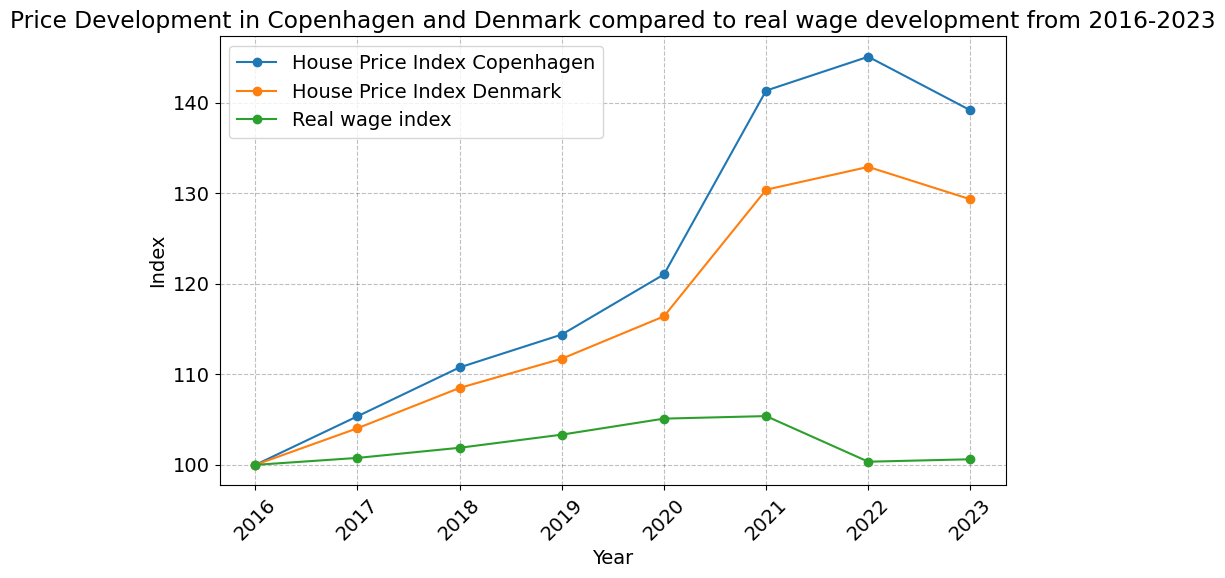

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))

merged_index.plot(ax=ax, x="Year", legend=True, marker='o')

ax.legend(frameon=True)
ax.set_xlabel('Year')
ax.set_ylabel('Index')
ax.set_title('Price Development in Copenhagen and Denmark compared to real wage development from 2016-2023')
ax.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# merged_index.plot(x="Year", y=["House Price Index Copenhagen", "House Price Index Denmark", "Real wage index"]) # Alternative one-liner but does not look as good

## Results ##
From the graph we can see from the period of 2016 to 2023 the real wage hasn't increased with the increase in housing prices, obviously not in Copenhagen but also not for all of Denmark. With two decades of almost no inflation, we can see the negative impact of inflation on the wages from 2022-2023. This of course creates a higher burden for families to support themselves, but also to finance a loan - ceteris paribus, disregarding the interest rate. This hurts especially first time buyers entering the markets in 2023, as it would have been an advantage to buy i.e. 2017 and get the house price increase along with the very small increase in the real wage of only 0.63%